In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

#Configurable parameters for pure pursuit
+ How fast do you want the robot to move? It is fixed at $v_{max}$ in this exercise
+ When can we declare the goal has been reached?
+ What is the lookahead distance? Determines the next position on the reference path that we want the vehicle to catch up to

In [2]:
vmax = 0.75
goal_threshold = 0.05
lookahead = 3.0

In [3]:
# Unicycle model
def simulate_unicycle(pose, v,w, dt=0.1):
    x, y, t = pose
    return x + v*np.cos(t)*dt, y + v*np.sin(t)*dt, t+w*dt

In [4]:
class PurePursuitTracker(object):
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 #index on the path that tracker is to track
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0 # For starting

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        
        #Calculate ref_x, ref_y using current ref_idx
        #Check if we reached the end of path, then return TRUE
        #Two conditions must satisfy
        #1. ref_idx exceeds length of traj
        #2. ref_x, ref_y must be within goal_threshold
        # Write your code to check end condition
        ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
        goal_x, goal_y = self.x[-1], self.y[-1]
        if (self.ref_idx > self.length) and \
            (np.linalg.norm([ref_x-goal_x, ref_y-goal_y])) < goal_threshold:
            # Ended, within goal
            return True
        
        #End of path has not been reached
        #update ref_idx using np.hypot([ref_x-xc, ref_y-yc]) < lookahead
        while np.hypot(ref_x-xc, ref_y-yc) < lookahead:
          self.ref_idx += 1 # Reached the current index, next
          if self.ref_idx < self.length:
            ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
          else:
            return True

        #Find the anchor point
        # this is the line we drew between (0, 0) and (x, y)
        anchor = np.asarray([ref_x - xc, ref_y - yc])
        #Remember right now this is drawn from current robot pose
        #we have to rotate the anchor to (0, 0, pi/2)
        #code is given below for this
        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        
        Lsq = (anchor[0] ** 2 + anchor[1] **2) # dist to reference path^2
        X = anchor[0] #cross-track error
        #from the derivation in notes, plug in the formula for omega
        self.w = -2*self.v*X/Lsq
        
        return False

## Visualize given trajectory

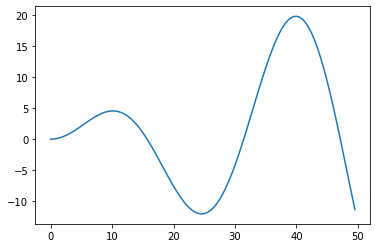

In [5]:
x = np.arange(0, 50, 0.5)
y = [np.sin(idx / 5.0) * idx / 2.0 for idx in x]

#write code here
plt.figure()
plt.plot(x,y)
plt.show()

## Run the tracker simulation

1. Instantiate the tracker class
2. Initialize some starting pose
3. Simulate robot motion 1 step at a time - get $v$, $\omega$ from tracker, predict new pose using $v$, $\omega$, current pose in simulate_unicycle()
4. Stop simulation if tracker declares that end-of-path is reached
5. Record all parameters

In [6]:
#write code to instantiate the tracker class
tracker = PurePursuitTracker(x, y, vmax) 
pose = -1, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting
traj =[]
while True:
    #write the usual code to obtain successive poses
    pose = simulate_unicycle(pose, tracker.v, tracker.w)
    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx])

ARRIVED!!


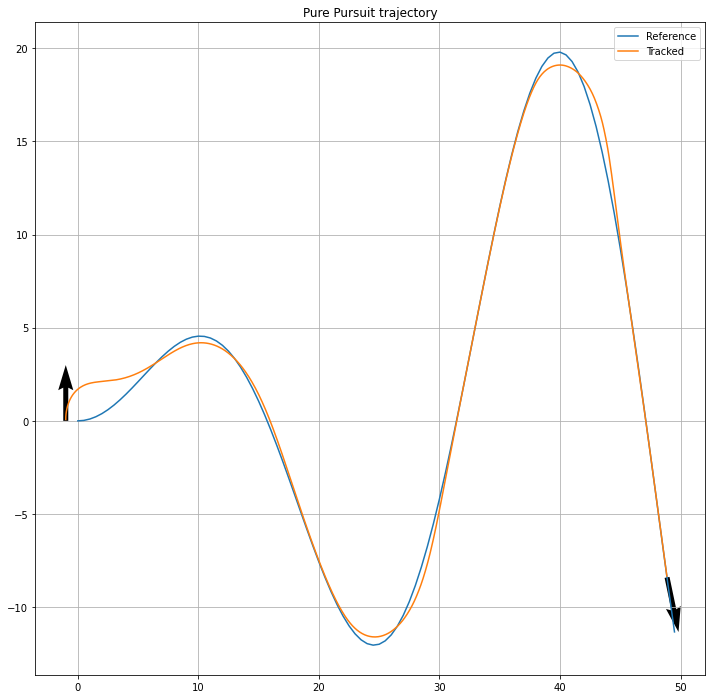

In [7]:
xs,ys,ts,ws,ids = zip(*traj)
plt.figure(figsize=(12,12))
plt.plot(x,y,label='Reference')
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.plot(xs,ys,label='Tracked')
xf,yf,tf = pose
plt.quiver(xf,yf, np.cos(tf), np.sin(tf),scale=12)
plt.title('Pure Pursuit trajectory')
plt.legend()
plt.grid()

# Visualize curvature

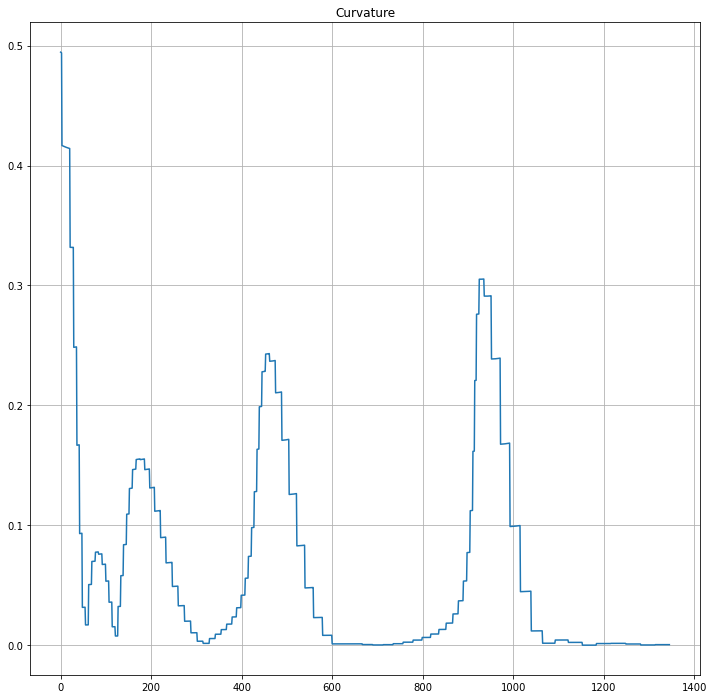

In [8]:
plt.figure(figsize=(12,12))
plt.title('Curvature')
plt.plot(np.abs(ws))
plt.grid()


## Animate

Make a video to plot the current pose of the robot and reference pose it is trying to track. You can use funcAnimation in matplotlib. A reference can be found [here](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/)

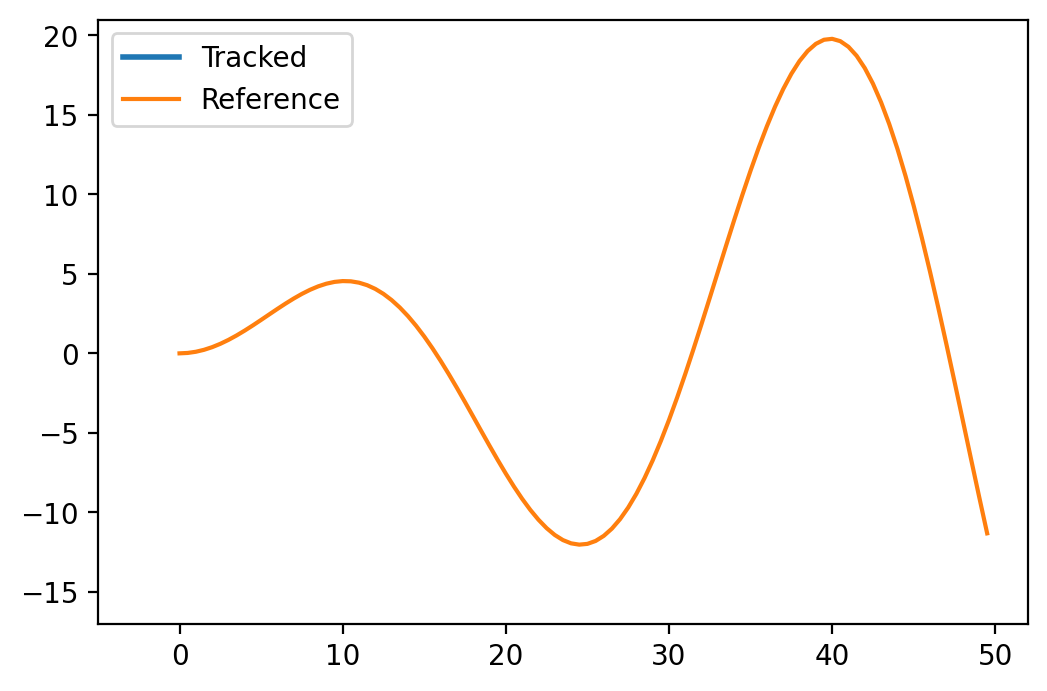

In [9]:
# Convert trajectory to Numpy array
np_traj = np.array(traj)  # N, 5 shape && float64
# Create figure and axis
fig, ax = plt.subplots()
fig.set_dpi(200)
ax.set_xlim((-5, 52))
ax.set_ylim((-17, 21))
# Get lines (to modify)
line_tracked, = ax.plot([], [], label="Tracked", lw=2.0)
line_ref = ax.plot(x,y,label='Reference')
ax.legend()

In [10]:
# Initialize everything
def init_func():
  line_tracked.set_data([], []) # Clear tracking data
  return (line_tracked, )
# Animation function
def animate(fnum):
  line_tracked.set_data(np_traj[:fnum, 0], np_traj[:fnum, 1])
  return (line_tracked, )
# Animation object
anim = animation.FuncAnimation(fig, animate, init_func=init_func,
                               frames=np_traj.shape[0], interval=20, blit=True)
HTML(anim.to_html5_video())

## Effect of noise in simulations

What happens if you add a bit of Gaussian noise to the simulate_unicycle() output? Is the tracker still robust?

The noise signifies that $v$, $\omega$ commands did not get realized exactly


In [11]:
# Unicycle model
def simulate_unicycle(pose, v,w, dt=0.1):
    x, y, t = pose
    t += np.random.normal(0.0, np.deg2rad(5))  # Localization orientation error
    x += np.random.normal(0.0, 0.1)
    y += np.random.normal(0.0, 0.1)
    return x + v*np.cos(t)*dt, y + v*np.sin(t)*dt, t+w*dt

Rest everything is the same as before

In [12]:
# Do the simulation
tracker = PurePursuitTracker(x, y, vmax) 
pose_noisy = -1, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose_noisy # record it for plotting
traj_noisy =[]
while True:
    #write the usual code to obtain successive poses
    pose_noisy = simulate_unicycle(pose_noisy, tracker.v, tracker.w)
    if tracker.update(*pose_noisy):
        print("ARRIVED!!")    
        break
    traj_noisy.append([*pose_noisy, tracker.w, tracker.ref_idx])

ARRIVED!!


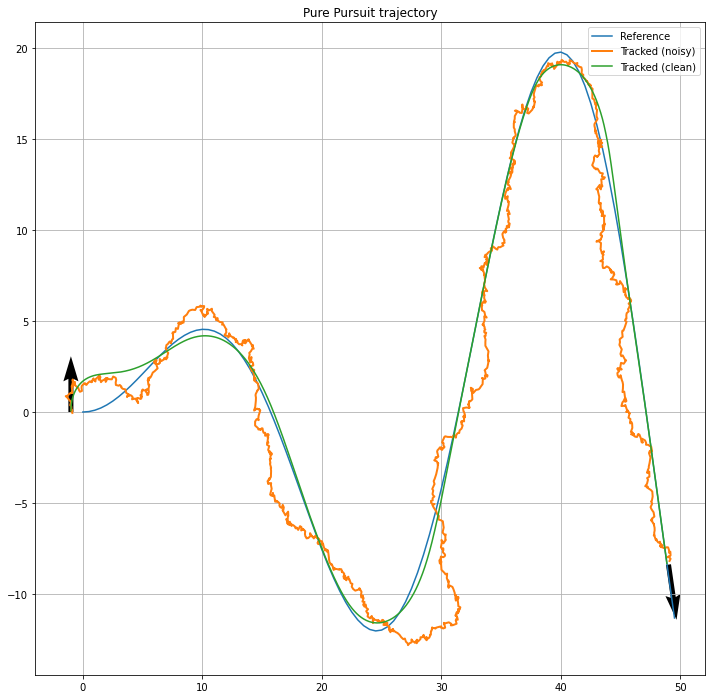

In [13]:
# Visualize everything
xs,ys,ts,ws,ids = zip(*traj_noisy)
xsc, ysc, tsc, wsc, idsc = zip(*traj) # Clean trajectory
plt.figure(figsize=(12,12))
# Reference
plt.plot(x,y,label='Reference')
plt.plot(xs,ys,label='Tracked (noisy)', lw=2.0)
plt.plot(xsc, ysc, label='Tracked (clean)')
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
xf,yf,tf = pose_noisy
plt.quiver(xf,yf, np.cos(tf), np.sin(tf),scale=12)
plt.title('Pure Pursuit trajectory')
plt.legend()
plt.grid()